# Recommender Systems

This is my attempt on building a recommender systems on MovieLens Dataset (100K)

About dataset : [http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html]

In [1]:
# importing necessary libraries

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import seaborn as sns

In [2]:
# Loading the data 

data = pd.read_csv('ratings.csv')

In [3]:
# This is how the data looks

data.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [4]:
# Let's do some very basic checks before moving forward

print ('Is there a presence of null values?\n{}'.format(data.isnull().sum()))

print ('\nDescription about ratings:\n{}'.format(data['rating'].describe()))

unique_rating = data['rating'].unique()
unique_rating.sort()
print ('\nUnique ratings: {}'.format(unique_rating))

print ('\nUnique #users: {}'.format(data['userId'].unique().shape[0]))

print ('\nUnique #movies: {}'.format(data['movieId'].unique().shape[0]))

Is there a presence of null values?
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Description about ratings:
count    100004.000000
mean          3.543608
std           1.058064
min           0.500000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

Unique ratings: [0.5 1.  1.5 2.  2.5 3.  3.5 4.  4.5 5. ]

Unique #users: 671

Unique #movies: 9066


In the cell below we have few utility functions that'll help us in the regression model for recommender systems

In [5]:
# Utility functions 

def train_test_split(df,way):
    '''This function will perform train and test split of the data'''
    if(way=='random'):
        df = df.sample(frac=1)
    elif(way=='time'):
        df = df.sort_values(by='timestamp')
    l = int(df.shape[0]*.8)
    train = df[:l]
    test = df[l:]
    
    X_train = train.drop(labels=['timestamp','rating'],axis=1); y_train = train['rating']
    X_test = test.drop(labels=['timestamp','rating'],axis=1); y_test = test['rating']

    return (X_train,y_train,X_test,y_test)

def center_scale(train,test,fet):
    '''This function takes in the test and train data and standardizes them'''
    fet_col = train[fet].tolist()
    mu = np.mean(fet_col); sig = np.std(fet_col)
    
    for i in range(len(fet_col)):
        fet_col[i] = (fet_col[i]-mu)/sig
    train[fet] = fet_col
    fet_col = test[fet].tolist()
    
    for i in range(len(fet_col)):
        fet_col[i] = (fet_col[i]-mu)/sig
    test[fet] = fet_col
    
    return (train,test)

In [6]:
# Splitting the dataset into train and test in a random fashion

X_train, y_train, X_test, y_test = train_test_split(data,'random')

C:\Users\Sanjay\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


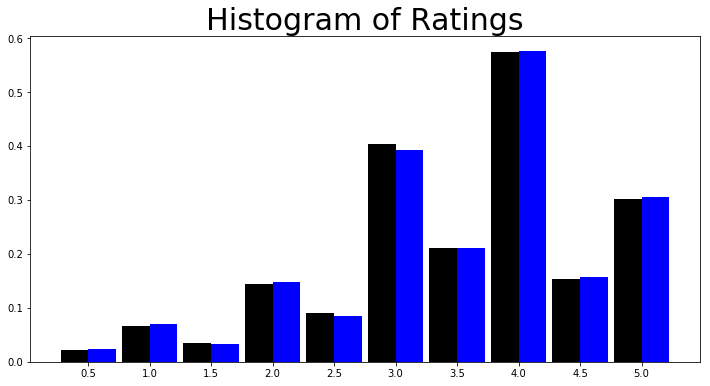

In [7]:
# Code below plots the histogram of the ratings BLACK is training set BLUE is testing set

plt.figure(figsize=(12,6))
bins = unique_rating.tolist() + [5.5]
plt.hist(x=[y_train,y_test],bins=bins,color=['black','blue'],normed=True,rwidth=0.9)
plt.xticks(unique_rating+.25,unique_rating)
plt.title('Histogram of Ratings',fontdict={'fontsize':30})
plt.show()

We can see that the distribution of ratings over the train and test data are same.

### Recommender system using regression

We are going to implement recommender system using regression techniques and record the metrics accordingly

In [8]:
# Now we would standardize our train and test data 

print ('===Standardizing these columns===\n')
for i, cn in enumerate(X_train[X_train.columns]):
    print (cn,end='\t')
    X_train, X_test = center_scale(X_train,X_test,cn)

===Standardizing these columns===

userId	movieId	

In the cell below we have functions that'll help us build the regression model and print the metrics

In [9]:
# Algorithms 

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error

def metric(observed, predicted):
    rmse = mean_squared_error(observed,predicted)**0.5
    mae = mean_absolute_error(observed,predicted)
    print ('\nRMSE: {}\nMAE: {}'.format(rmse,mae))
    
def ridge_regressor(X_train,X_test,y_train,param):
    '''Implements Ridge regression with hyperparameter tuning'''
    
    ridge = Ridge()
    reg = GridSearchCV(ridge,param)
    reg.fit(X_train,y_train)

    rid_parameters = ridge.get_params()
    rid_parameters['alpha'] = reg.best_params_['alpha']

    ridge.set_params(**rid_parameters)
    print ('\n---Parameters for Ridge Regression---\n{}'.format(ridge.get_params))

    ridge.fit(X_train,y_train)
    y_pred = ridge.predict(X_test)
    
    return (y_pred)

In [10]:
# Lets try a our naive 1st cut solution which is a very simple form of ridge regression with hyper parameter tuning

initial = datetime.datetime.now()

#alpha = [0.125,0.25,0.5,1,2,4,8] # We had previously tried on this range. Now I would like to explore a larger range.
alpha = [0.001,0.01,0.1,1,10,100]
parameter = {'alpha':alpha}

y_pred = ridge_regressor(X_train,X_test,y_train,parameter)

print ('\n===METRICS===')
metric(y_test,y_pred)

final = datetime.datetime.now()

print ('\nTime required =',final-initial)


---Parameters for Ridge Regression---
<bound method BaseEstimator.get_params of Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)>

===METRICS===

RMSE: 1.066698503735705
MAE: 0.8563265025436632

Time required = 0:00:00.770394


The above metrics are for the 1st cut solution of the recommender system implementation. With a MAE of 0.85, it's not a bad start. Let's see what else we can do with our models and let's also monitor the metrics of other different models.

----

### Recommender system using regression and a little bit of feature engineering

We are going to try to modify the previous model by doing some sort of feature engineering on our data.

In the cell below we have 2 functions that create user and movie features. Read the function documentation to understand what they are doing.

In [11]:
# functions for feature engineering 

def user_features(df):
    '''This function will create 2 user dependent features such as 
        the mean ratings given by the user and the std dev of the ratings'''
    userid = df['userId'].tolist()
    mean_ratings = list(); stddev_ratings = list()
    for uid in userid:
        uid_df = df.loc[df['userId']==uid]
        ratings = uid_df['rating'].tolist()
        mean = np.mean(ratings); std_dev = np.std(ratings)
        
        mean_ratings.append(mean); stddev_ratings.append(std_dev)
        
    df['mean_ratings_u'] = mean_ratings
    df['stddev_ratings_u'] = stddev_ratings
    
    return df

def movie_features(df):
    '''This function will create 2 movie dependent features such as the 
        mean ratings that the movie got and the std dev of the ratings that the movie got'''
    movid = df['movieId'].tolist()
    mean_ratings = list(); stddev_ratings = list()
    for mid in movid:
        mid_df = df.loc[df['movieId']==mid]
        ratings = mid_df['rating'].tolist()
        mean = np.mean(ratings); std_dev = np.std(ratings)
        
        mean_ratings.append(mean); stddev_ratings.append(std_dev)
        
    df['mean_ratings_m'] = mean_ratings
    df['stddev_ratings_m'] = stddev_ratings
    
    return df

In [12]:
# We need to reload the data before feature engineering

data = pd.read_csv('ratings.csv')

In [13]:
# Feature enginnering 

initial = datetime.datetime.now()

data = user_features(data) # this will add user-dependent features 

data = movie_features(data) # this will add movie-dependent features

final = datetime.datetime.now()

print ('\nTime required =',final-initial)


Time required = 0:01:49.870061


In [14]:
# Let's look at the data now.

data.head()

,userId,movieId,rating,timestamp,mean_ratings_u,stddev_ratings_u,mean_ratings_m,stddev_ratings_m
0,1,31,2.5,1260759144,2.55,0.864581,3.178571,0.829669
1,1,1029,3.0,1260759179,2.55,0.864581,3.702381,0.859537
2,1,1061,3.0,1260759182,2.55,0.864581,3.545455,0.762409
3,1,1129,2.0,1260759185,2.55,0.864581,3.312500,0.801204
4,1,1172,4.0,1260759205,2.55,0.864581,4.260870,0.870651


We can see that there are now 4 extra columns 
* mean_ratings_u: is the mean rating given by that particular user
* stddev_ratings_u: is the standard deviation of the ratings given by that user
* mean_ratings_m:  is the mean ratings that particular movie got
* stddev_ratings_m: is the standard deviation of the ratings that a particular movie got.

In [15]:
# we are spillting the data into train and test set in random fashion

X_train, y_train, X_test, y_test = train_test_split(data,'random')

In [16]:
# Now we would standardize our train and test data 

print ('===Standardizing these columns===\n')
for i, cn in enumerate(X_train[X_train.columns]):
    print (cn,end='\t')
    X_train, X_test = center_scale(X_train,X_test,cn)

===Standardizing these columns===

userId	movieId	mean_ratings_u	stddev_ratings_u	mean_ratings_m	stddev_ratings_m	

In [17]:
# Trying out the same algorithm for ridge regression after feature engineering 

initial = datetime.datetime.now()

#alpha = [0.125,0.25,0.5,1,2,4,8] # We had previously tried on this range. Now I would like to explore a larger range.
alpha = [0.001,0.01,0.1,1,10,100]
parameter = {'alpha':alpha}

y_pred = ridge_regressor(X_train,X_test,y_train,parameter)

print ('\n===METRICS===')
metric(y_test,y_pred)

final = datetime.datetime.now()

print ('\nTime required =',final-initial)


---Parameters for Ridge Regression---
<bound method BaseEstimator.get_params of Ridge(alpha=10, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)>

===METRICS===

RMSE: 0.8337655216879091
MAE: 0.6387381172964315

Time required = 0:00:00.305771


We can see the above metric. Previously we had a MAE of ~ 0.85 now we have around 0.63 which is a very significant increase in the performance. Hence we can say our feature engineering really works.


----

### User-user similarity based recommender system

Here I have implemented the user-user similarity based recommender system completely from scratch.
<br>I'm defining user A and B as similar users if they have common movies that they have rated (this should include the movie that is our current test point)
<br>Degree similarity between two users is the eucledian distance determined by the rating vector of common movies. Lower the distance, greater is the similarity.
<br>Predicted rating would be the mean rating of the most similar users on the test movie.


In the cell below I have some utility functions that I made that'll help me implement the user-user similarity recommender system. The descriptions about the functions are given in the function documentation itself.

In [18]:
# Utility functions for recommending engine 


def eliminate_users(df, threshold):
    '''This function will eliminate those users who haven't rated atleast "threshold" movies '''
    unique_uids = df['userId'].unique().tolist()
    for uid in unique_uids:
        uid_df = df.loc[df['userId']==uid]
        if(uid_df.shape[0]<threshold):
            df = df.loc[df['userId']!=uid]
            
    return df

def eliminate_movie(df, threshold):
    '''This function will eliminate those movies which havent been rated atleast "threshold" times'''
    unique_mids = df['movieId'].unique().tolist()
    for mid in unique_mids:
        mid_df = df.loc[df['movieId']==mid]
        if(mid_df.shape[0]<threshold):
            df = df.loc[df['movieId']!=mid]
            
    return df

def create_ds(df):
    '''This will create a dictionary where the key will the userid and the 
        content will be a set of the movieid that a particular user has rated'''
    content_dict = dict()
    unique_uids = df['userId'].unique().tolist()
    for uid in unique_uids:
        uid_df = df.loc[df['userId']==uid]
        mids = uid_df['movieId'].unique()
        content_dict[uid] = set(mids)
        
    return content_dict

def get_distance(x, y):
    '''This will return the eucledian distance between x and y'''
    if (len(x)!= len(y)):
        print ('error')
    
    x = np.array(x); y = np.array(y)

    return (np.sqrt(np.sum((x-y)**2)))

def get_similar_user(uid, mid, index):
    '''This function will return all the users which are similar to uid
        and similarity is determined if they have atleast 10 movies in common including mid'''
    mset = index[uid]; similar_uid = list()
    for other_uid in index.keys():
        if(other_uid != uid and mid in index[other_uid]):
            other_mset = index[other_uid]
            if(len(mset.intersection(other_mset))>=10):
                similar_uid.append(other_uid)
                
    return similar_uid

def get_similarity_degree(uid, mid, similar_uid, index, df):
    '''This will return the similarity degree between uid and the similar_users
        similarity degree is determined the eucledian distance of the ratings of the common movie'''
    similarity_degree = list()
    for other_uid in similar_uid:
        intersection_point = index[uid].intersection(index[other_uid])
        #print (intersection_point)
        intersection_point = list(intersection_point); a = []; b = []
        for i in intersection_point:
            if(i != mid):
                rating_a =  df[(uid,i)] # df.loc[df['movieId'] == i]; rating_a = rating_a.loc[rating_a['userId'] == uid]
                rating_b =  df[(other_uid,i)] # df.loc[df['movieId'] == i]; rating_b = rating_b.loc[rating_b['userId'] == other_uid]
                a.append(rating_a); b.append(rating_b)

        similarity_degree.append(get_distance(a,b))        
            
    return similarity_degree

def convert_dataframe(df):
    uid = df['userId'].tolist()
    mid = df['movieId'].tolist()
    rating = df['rating'].tolist()
    
    dataframe_dict = dict()
    
    for i in range(len(uid)):
        dataframe_dict[(uid[i],mid[i])] = rating[i]
        
    return dataframe_dict

def predict_rating(distance_vector, SIMILAR_USERS, mid, df, tth_percentile):
    ''' this function will get the most similar users from the similar users (determined by applying the
        threshold on the eucledian distance) and then find what ratings they gave to the test rating and return
        prediction as their mean'''
    try:
        threshold = np.percentile(distance_vector,tth_percentile)
    except: 
        return "ERROR"

    most_similar = list()

    for i in range(len(distance_vector)):
        if(distance_vector[i] <= threshold):
            most_similar.append(SIMILAR_USERS[i])

    rating_vector = list()

    for i in range(len(most_similar)):
        flag = df[(most_similar[i],mid)] # flag = df.loc[df['userId']==most_similar[i]]
                                         # flag = flag.loc[flag['movieId']==mid]
        rating_vector.append(flag)

    return (np.mean(rating_vector))

In [19]:
# Reload the data as it's a fresh approach to recommender systems

data = pd.read_csv('ratings.csv')

In [20]:
# First parameter for this implemetation, this is for the number of movies that a user needs to rate atleast and the minimum number of ratings a movie must have inorder to be considered by this algorithm

param1 = 10

In [21]:
print ('Size before the operation --- {}'.format(data.shape[0]))

# Eliminating users who haven't rated atleast  param1 movies
data = eliminate_users(data,param1)

# Eliminating movies that haven't been rated atleast param1 times
data = eliminate_movie(data,param1)

print ('\nSize after the operation --- {}'.format(data.shape[0]))

# Now we will create a dictionary where the key will be the userIds and the content will be set of the movieId that the user has rated
index = create_ds(data)

Size before the operation --- 100004

Size after the operation --- 81915


In [22]:
# Here we will convert the information in our dataframe to a dictionary for much faster access
# dict format: 
# key = (userId, movieID); value = rating

data_dict = convert_dataframe(data)

# Lets see how the data looks
print (data_dict[1,1029]) # userId = 1 and movieId = 1029

3.0


In [23]:
# 2nd parameter in this implementation, this is the nth percentile that'll separate the most similar users from the set of all similar users

param2 = 75 

In [24]:
# The main purpose of the caller_func() is to integrate the previous utility functions.

def caller_func():
    '''This caller function will pick a random point from the dataframe and treat it as a test point.
    It'll get the similar users, degree of similarity and then predict rating '''
    test_point = data.sample(n=1)
    test_uid = int(test_point['userId']); test_mid = int(test_point['movieId'])

    similar_users = get_similar_user(test_uid,test_mid,index)

    distances = get_similarity_degree(test_uid,test_mid,similar_users,index,data_dict)

    #sns.distplot(distances)

    observed = float(test_point['rating'])
    predicted = predict_rating(distances,similar_users,test_mid,data_dict, param2) # param2 is the t-th percentile for choosing most-similar users
    
    if (predicted == "ERROR"):
        return ("ERROR", "ERROR")
    
    return (observed,predicted)

In [25]:
initial = datetime.datetime.now()

n = int(0.2*data.shape[0]); # 20% of the total size
obs = list(); pred = list()
while(n>0): 
    n = n-1
    o,p = caller_func()
    if (o=="ERROR" or p == "ERROR"):
        continue
    obs.append(o); pred.append(p)
    
metric(obs,pred)

final = datetime.datetime.now()

print ('\nTime required =',final-initial)


RMSE: 0.9421296447411392
MAE: 0.723495951243854

Time required = 0:02:23.270263


So in this implementation of our recommender system we are getting the above metrics when tested on random points 20% of the data ~ 16k

We can see that our implementation of user-user similarity based recommender system resulted in the above metrics. MAE of 0.72 is not at all a bad metric. My hypothesis is this results will improve as users start rating more number of movies as then the set of common movies would increase and it would be more easier to judge who is most similar and who isn't.


---

### Simple Matrix factorization model using Spotlight

Credits: [https://github.com/maciejkula/spotlight] 

<br>

Here I've used a library for matrix factorization which is called spotlight. You can find more about the library in the given link.

In [1]:
from spotlight.cross_validation import random_train_test_split
from spotlight.datasets.movielens import get_movielens_dataset
from spotlight.evaluation import rmse_score
from spotlight.factorization.explicit import ExplicitFactorizationModel

dataset = get_movielens_dataset(variant='100K')

train, test = random_train_test_split(dataset)

model = ExplicitFactorizationModel(n_iter=1)
model.fit(train)

rmse = rmse_score(model, test)

In [2]:
print ('\nRMSE: {}'.format(rmse))


RMSE: 1.003307580947876
